### 0.1. Import libaries, model and etc.

In [5]:
import pychrono.core as chr
import pychrono.irrlicht as chrirr
import numpy as np
import matplotlib.pyplot as plt
import time
import control_locomotion as ctrl
import leg as l
import quadruped_corpus as corpus
import simulate

from scipy.optimize import differential_evolution

### 0.2. Function for optimization

Function for stopping simulation

In [2]:
class MinimizeStopper(object):
    def __init__(self, max_sec=0.3):
        self.max_sec = max_sec
        self.start = time.time()

    def __call__(self, xk=None, convergence=None):
        elapsed = time.time() - self.start
        if elapsed > self.max_sec:
            print("Terminating optimization: time limit reached")
            return True
        else:
            # you might want to report other stuff here
            # print("Elapsed: %.3f sec" % elapsed)
            return False

Calculate cost function

In [3]:
def CostFunc(p, gait_period, eval_times, time_step, time_simulation, desired_velocity):
    points = np.array(p[0:np.size(p)-2])
    offsets_legs = {"front": p[np.size(p)-2], "rear":p[-1]}
    #print(points)
    #print(offsets_legs)
    str_coord =chr.ChVectorD(0,0.6,0) 
    quadruped = corpus.quadruped(str_coord)
    sim = simulate.Simulate(quadruped,time_step,time_simulation)
    locomotion = ctrl.ControlLocomotion(points,gait_period,eval_times,offsets_legs)
    quadruped.setLocomotion(locomotion)
    sim.startNoAnimation()
    reward = sim.getReward(desired_velocity)
    del sim, quadruped, locomotion, str_coord
    print(f"reward: {reward}")
    return reward

### Simulate previus result

In [8]:
import json
with open('result.txt', 'r') as fr:
    x = json.load(fr)


num_points = 6
desired_velocity = 0.375
gait_period = 1.2
eval_times = 0.0001

points = np.array(x[0:np.size(x)-2])
offsets_legs = {"front": x[np.size(x)-2], "rear":x[-1]}
str_coord =chr.ChVectorD(0,0.6,0) 
quadruped = corpus.quadruped(str_coord)
sim = simulate.Simulate(quadruped,0.01,10)
locomotion = ctrl.ControlLocomotion(points,gait_period,eval_times,offsets_legs)
quadruped.setLocomotion(locomotion)

sim.initilizeAnimation()
sim.start()
reward = sim.getReward(desired_velocity)
print(f"reward: {reward}")



x_stop: 1.0816090189327803, time_stop: 5.539999999999926, agressive: 1
reward: 1.5117844187509237


## Optimization

### 1. Set parameters locomotion

In [7]:
num_points = 6
desired_velocity = 0.375
gait_period = 1.2
eval_times = 0.0001

time_step = 0.01
time_simulation = 10

### 2. Optimzation parameters

In [8]:
max_iteratation = 100
population_size = 30

time_stop_optimization = 21600

stopper = MinimizeStopper(time_stop_optimization)

bound_fr_hip = [(-np.pi/3, np.pi/3) for i in range(num_points)]
bound_fr_knee = [(-np.pi/3, np.pi/3) for i in range(num_points)]
bound_rr_hip = [(-np.pi/3, np.pi/3) for i in range(num_points)]
bound_rr_knee = [(-np.pi/3, np.pi/3) for i in range(num_points)]
bound_offsets = [(30, 60) for i in range(2)]
bounds = (bound_fr_hip + bound_fr_knee +
          bound_rr_hip + bound_rr_knee +
          bound_offsets)

### 3. Run optimization

In [9]:
result = differential_evolution(CostFunc,bounds,
                                strategy="best1exp",
                                maxiter = max_iteratation,
                                popsize= population_size,
                                updating="deferred",
                                polish=False,
                                callback=stopper,
                                args = (gait_period,eval_times,
                                        time_step,time_simulation,
                                        desired_velocity))
print(result)

x_stop: -0.4751506693996503, time_stop: 1.390000000000001, agressive: 2
reward: 1912.8688343655876
x_stop: 0.47832670209005446, time_stop: 1.1600000000000008, agressive: 3
reward: 4729.311161448256
x_stop: -0.46309738694505215, time_stop: 0.9800000000000006, agressive: 1
reward: 3848.829645612046
x_stop: 0.47181349626455515, time_stop: 0.9800000000000006, agressive: 3
reward: 9320.795941848808
x_stop: 0.38653738765981827, time_stop: 0.7200000000000004, agressive: 2
reward: 16838.492763539707
x_stop: 0.023899096478755637, time_stop: 1.8200000000000014, agressive: 3
reward: 1012.310305449666
x_stop: -0.4262398048203515, time_stop: 0.8500000000000005, agressive: 3
reward: 26729.14955691182
x_stop: -0.41842606078382893, time_stop: 0.8400000000000005, agressive: 3
reward: 27920.105023469096
x_stop: -0.47966265708820227, time_stop: 1.330000000000001, agressive: 2
reward: 2286.9932847187497
x_stop: -0.45677237791397546, time_stop: 0.8500000000000005, agressive: 3
reward: 27121.41295561875
x_s

Simulation with animation

In [13]:
points = np.array(result.x[0:np.size(result.x)-2])
offsets_legs = {"front": result.x[np.size(result.x)-2], "rear":result.x[-1]}
str_coord =chr.ChVectorD(0,0.6,0) 
quadruped = corpus.quadruped(str_coord)
sim = simulate.Simulate(quadruped,time_step,time_simulation)
locomotion = ctrl.ControlLocomotion(points,gait_period,eval_times,offsets_legs)
quadruped.setLocomotion(locomotion)

sim.initilizeAnimation()
sim.start()
reward = sim.getReward(desired_velocity)
print(reward)




584.9306604978655


Save the optimize locomotion

In [14]:
import json
time_data = time.localtime()

save_file = f"result_{reward}_date_{time_data.tm_hour}h_{time_data.tm_min}m_{time_data.tm_mday}d_{time_data.tm_mon}m_{time_data.tm_year}y.txt"
save_data = {"p": result.x, "gait_period":gait_period,"eval_times":eval_times,"desired_velocity":desired_velocity,"reward":reward}
with open(save_file, 'w') as fw:
    json.dump(list(result.x),fw)
    #json.dump(save_data,fw,sort_keys=True, separators=(",",":"))

## Plot

Plot resulting trajectory: Gait Legs

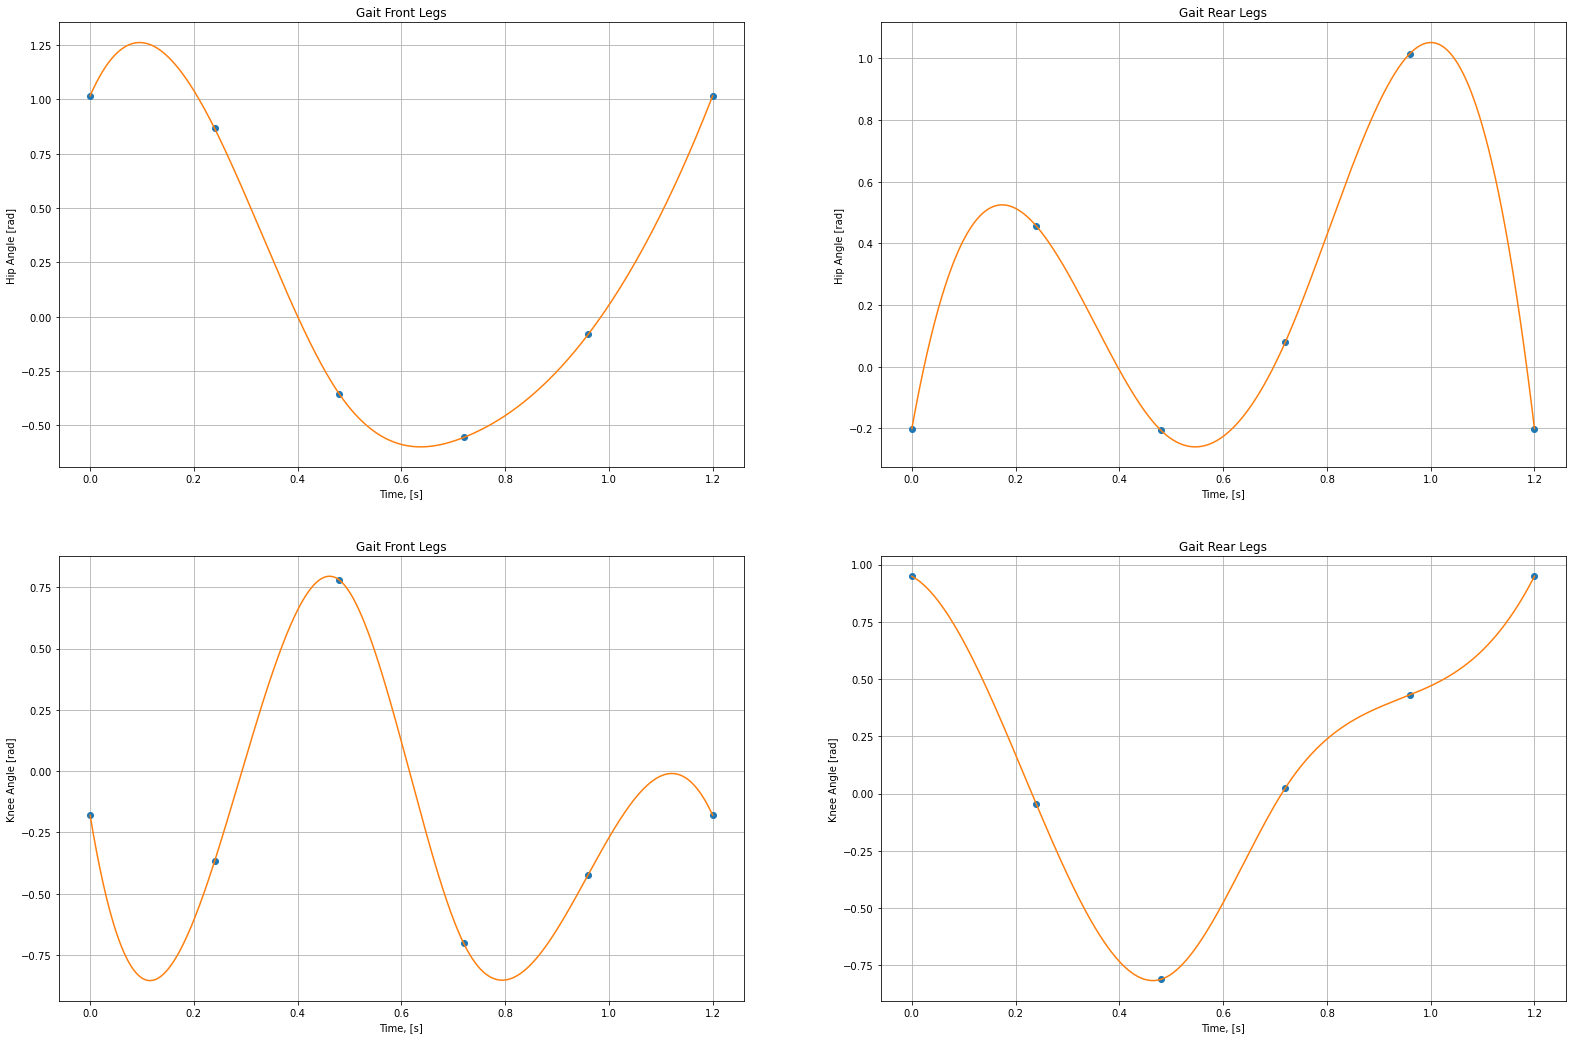

In [3]:
plt.figure(figsize=(27,18))

k = 1
for idx in locomotion.ger_indexMotors():
    plt.subplot(2,2,k)
    if np.mod(k,2) != 0:
        plt.title("Gait Front Legs")
    else:
        plt.title("Gait Rear Legs")
    if k >=3:
        plt.ylabel("Knee Angle [rad]")
    else:
        plt.ylabel("Hip Angle [rad]")
    plt.plot(locomotion.get_pointsMotor(idx)[:,0],locomotion.get_pointsMotor(idx)[:,1],'o',locomotion.get_trajMotor(idx)[:,0],locomotion.get_trajMotor(idx)[:,1])
    plt.xlabel("Time, [s]")
    plt.grid(True)
    k += 1


Plot resulting locmotion

Text(0, 0.5, 'v_x, [m/s]')

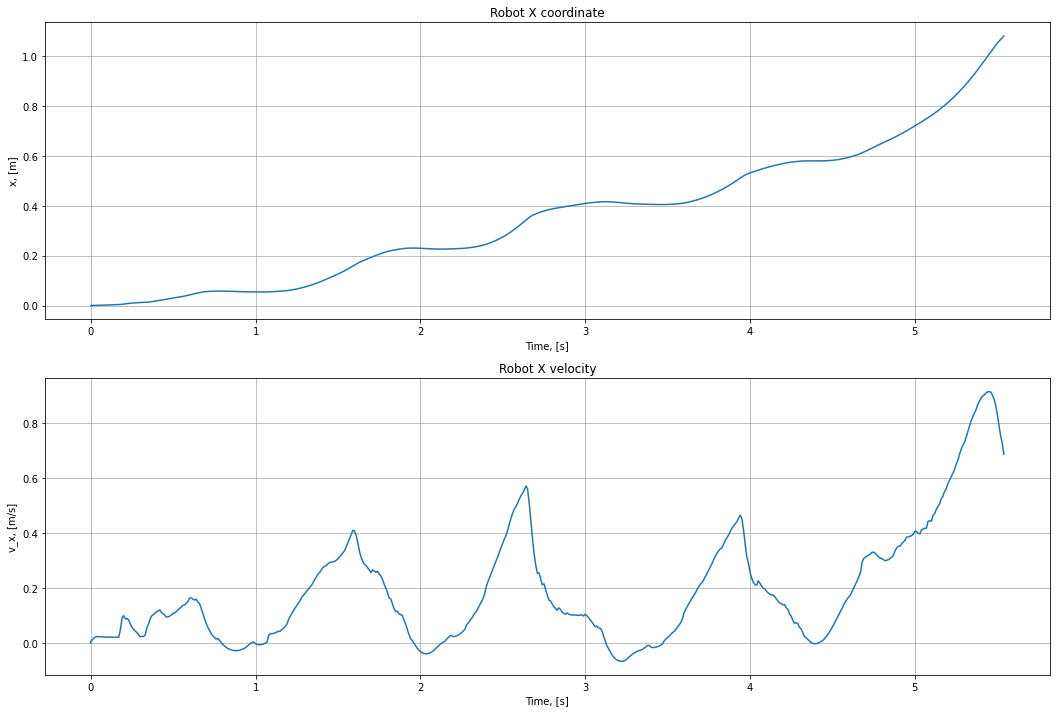

In [4]:
plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
plt.title("Robot X coordinate")
plt.plot(quadruped.getTrajX()[0,:],quadruped.getTrajX()[1,:])
plt.grid(True)
plt.xlabel("Time, [s]")
plt.ylabel("x, [m]")
plt.subplot(2,1,2)
plt.title("Robot X velocity")
plt.plot(quadruped.getVelX()[0,:],quadruped.getVelX()[1,:])
plt.grid(True)
plt.xlabel("Time, [s]")
plt.ylabel("v_x, [m/s]")